In [27]:
# Автоматическая перезагрузка модулей при изменении
# Позволяет обновлять код в helper.py, plots.py, nlp.py без перезапуска ядра
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Импорт библиотек для классического ML и нейронных сетей
import pandas as pd
import numpy as np
import random 

# Импорт sklearn для классических алгоритмов
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Импорт TensorFlow/Keras для нейронных сетей
import tensorflow as tf
from tensorflow.keras.utils import set_random_seed, to_categorical
from tensorflow.keras.regularizers import l2 as l2_reg
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.config.experimental import list_physical_devices
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Пользовательские модули
from helper import *        # вспомогательные функции
from plots import *         # функции визуализации
from nlp import *          # функции обработки естественного языка
from transformers import * # функции для работы с трансформерами
from keras_helper import * # функции для работы с Keras

In [29]:
# Проверка GPU
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU доступен: {len(gpus)} устройств")
else:
    print("GPU недоступен, используется CPU")


GPU недоступен, используется CPU


In [30]:
# Фиксация состояния генератора псевдослучайных чисел для воспроизводимости
# Критически важно для машинного обучения - результаты должны быть воспроизводимы
SEED = 42 # можно указать любое число
np.random.seed(SEED)  # для numpy операций
random.seed(SEED)     # для стандартного модуля random
tf.random.set_seed(SEED) # для TensorFlow/
tf.keras.utils.set_random_seed(SEED) #для Keras

In [31]:
# Загружаем предобработанные данные
df = pd.read_csv('imdb.csv')

## 1. Препроцессинг и бейслайн

**Цель:** Подготовить данные для обучения нейронных сетей и создать baseline модель для сравнения.
Нейронные сети требуют специальной предобработки - объединения текстов и создания последовательностей.

In [32]:
# Создаем копию данных для предобработки
df_preprocessed = df.copy()

# Преобразуем целевую переменную в числовой формат
df_preprocessed['is_positive'] = df_preprocessed['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# # Токенизируем тексты с помощью tiktoken (токенизатор GPT)
# # Это необходимо для дальнейшей векторизации текстов
df_preprocessed['review'] = df_preprocessed['review'].apply(tokenize_tiktoken)

In [33]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X, y = divide_data(df_preprocessed, 'is_positive')

In [34]:
# Создаем baseline модель LGBM для сравнения с нейронными сетями
lgbm_classifier = LGBMClassifier(random_state=SEED, verbose=-1)

In [35]:
# Настраиваем кросс-валидацию с 3 фолдами (меньше для ускорения обучения нейронных сетей)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

In [36]:
# Создаем пайплайн для векторизации текстов (для baseline модели)
count_vectorizer_preprocessor = Pipeline([
    ('vectorizer', ColumnTransformer(
        [
            # Векторизация описаний: analyzer=lambda x: x означает, что вход уже токенизирован
            # Векторизация описаний: min_df=50 исключает слова, встречающиеся менее 50 раз
            ('vectorizer', CountVectorizer(analyzer=lambda x: x, min_df=50, dtype=np.float32), 'review')
        ],
        verbose_feature_names_out=True  # для отладки имен признаков
    )),
])

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have va

<Figure size 1500x600 with 0 Axes>

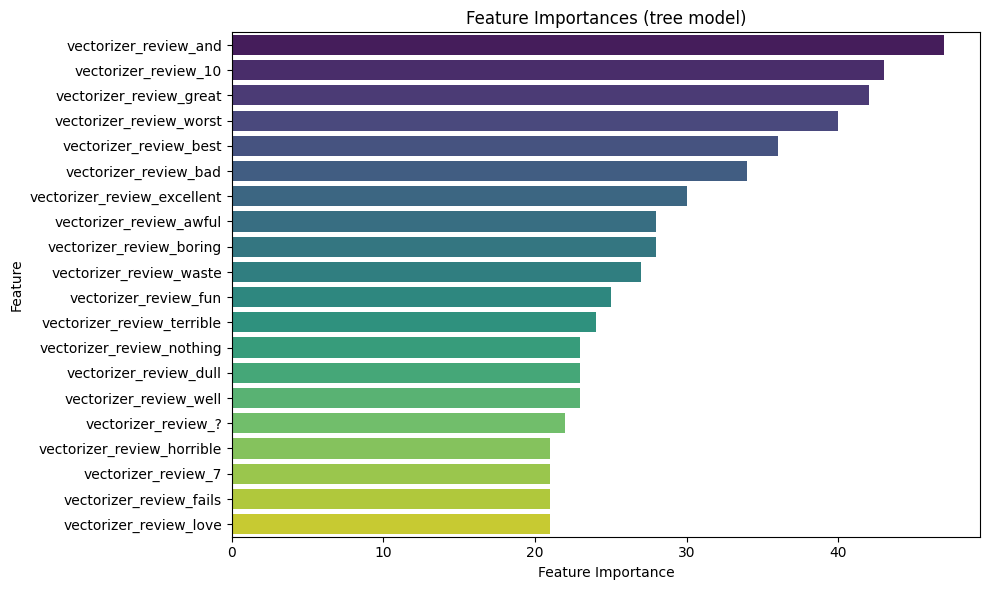

In [37]:
# Обучаем baseline модель LGBM для сравнения с нейронными сетями

baseline_metrics = train_evaluate_model_cv(
    model=lgbm_classifier,
    model_name='LGBMClassifier',
    X=X,
    y=y,
    preprocessor=count_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)


In [ ]:
# Выводим метрики baseline модели
print_metrics_beautifully(base_metrics)

["('name', 'LGBMClassifier')",
 "('training_time', 36.24663782119751)",
 "('estimators', None)",
 "('roc_auc', 0.9407696285356058)",
 "('f1_score', 0.8654799615357337)",
 "('precision', 0.8657152834473377)",
 "('recall', 0.8655000507675695)",
 "('accuracy', 0.8654999334910697)",
 "('confusion_matrix', None)",
 "('classification_report', None)",
 "('roc_curve', None)"]

## Препроцессинг перед использованием нейросетей

**Цель:** Подготовить данные для нейронных сетей, которые работают с последовательностями токенов.
Нейронные сети не могут напрямую работать с несколькими отдельными текстами, поэтому объединяем их.

In [39]:
# Параметры для нейронных сетей
MAX_NUM_WORDS = 100        # максимальное количество уникальных слов в словаре
MAX_SEQUENCE_LENGTH = 600  # максимальная длина последовательности токенов (575 было в eda для 90%, поэтому оставляем основную часть без выбросов)

In [40]:
# Разделяем данные на признаки (объединенные тексты) и целевую переменную
X, y = divide_data(df_preprocessed, 'is_positive')

#Сократим треничровочную выборку до 30%
ratio = 0.3
X, X_residual, y, y_residual = train_test_split(X, y, random_state = SEED, stratify = y, train_size = ratio)

In [41]:
# Демонстрация процесса предобработки для нейронных сетей
X_lol = X.copy()

# Отбираем топ-100 наиболее важных токенов для создания словаря
feature_selector = NgramFeatureSelector(top_k=MAX_NUM_WORDS)
X_lol['review'] = feature_selector.fit_transform(X_lol['review'])

In [42]:
# Преобразуем токены в последовательности чисел для нейронных сетей. Padding справа т.к. нужна полностью заполненная матрица и обработка идет слева направо
vect = SequenceVectorizer(min_frequency=50, max_sequence_length=MAX_SEQUENCE_LENGTH, pad_left=False) 
X_lol = vect.fit_transform(X_lol['review'])

In [43]:
# Результат: каждая строка - это последовательность индексов токенов
# Длина каждой последовательности <= MAX_SEQUENCE_LENGTH (600), но доведена искуственно справа до 600
X_lol

array([[ 2, 24, 81, ...,  0,  0,  0],
       [ 9, 41, 84, ...,  0,  0,  0],
       [64, 13,  2, ...,  0,  0,  0],
       ...,
       [91, 32, 14, ...,  0,  0,  0],
       [14,  9, 42, ...,  0,  0,  0],
       [ 3, 29,  8, ...,  0,  0,  0]], shape=(15000, 600), dtype=int32)

In [44]:
# Создаем пайплайн предобработки для нейронных сетей
RNN_preprocessor = Pipeline([
    ('token_selector', NgramFeatureSelector(top_k=100)),  # отбираем топ-100 важных токенов
    ('seq_vec', SequenceVectorizer(                       # преобразуем в последовательности
        min_frequency=50,                                 # минимальная частота токена
        max_sequence_length=MAX_SEQUENCE_LENGTH,          # максимальная длина последовательности
        pad_left=False                                    # дополнение справа (стандарт для RNN)
    ))
])

## 2. RNN (Рекуррентная нейронная сеть)

**Логика:** RNN обрабатывает последовательности токенов слева направо, сохраняя информацию о предыдущих токенах.
Используем Bidirectional RNN для анализа контекста в обе стороны. Это базовая архитектура для сравнения с более сложными.

Fold 1


/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 600, 10)        │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 16)             │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331 (5.20 KB)

 Trainable params: 1,331 (5.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - AUC: 0.7159 - loss: 0.6160
Epoch 2/50
 2/40 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - AUC: 0.8306 - loss: 0.5497

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `auc` which is not available. Available metrics are: AUC,loss
  current = self.get_monitor_value(logs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - AUC: 0.8331 - loss: 0.5071
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - AUC: 0.8453 - loss: 0.4907
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - AUC: 0.8473 - loss: 0.4860
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - AUC: 0.8526 - loss: 0.4799
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - AUC: 0.8525 - loss: 0.4805
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - AUC: 0.8527 - loss: 0.4824
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - AUC: 0.8226 - loss: 0.5229
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - AUC: 0.8466 - loss: 0.4908
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - AUC: 0.8359 - loss: 0.5023
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - AUC: 0.7741 - loss: 0.5719
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - AUC: 0.7686 - loss: 0.5824
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - AUC: 0.7677 - loss: 0.5817
Epoch 14/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 600, 10)        │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 16)             │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331 (5.20 KB)

 Trainable params: 1,331 (5.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - AUC: 0.5775 - loss: 0.6841
Epoch 2/50
 2/40 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - AUC: 0.6732 - loss: 0.6605

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `auc` which is not available. Available metrics are: AUC,loss
  current = self.get_monitor_value(logs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - AUC: 0.7168 - loss: 0.6226
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - AUC: 0.8021 - loss: 0.5432
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - AUC: 0.8466 - loss: 0.4885
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - AUC: 0.8551 - loss: 0.4773
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - AUC: 0.8621 - loss: 0.4672
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - AUC: 0.8560 - loss: 0.4777
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - AUC: 0.8690 - loss: 0.4574
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - AUC: 0.8587 - loss: 0.4716
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - AUC: 0.8727 - loss: 0.4526
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - AUC: 0.8662 - loss: 0.4621
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - AUC: 0.8740 - loss: 0.4511
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - AUC: 0.8578 - loss: 0.4776
Epoch 14/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 600, 10)        │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 16)             │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331 (5.20 KB)

 Trainable params: 1,331 (5.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - AUC: 0.7489 - loss: 0.5950
Epoch 2/50
 2/40 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - AUC: 0.8535 - loss: 0.5117

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `auc` which is not available. Available metrics are: AUC,loss
  current = self.get_monitor_value(logs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - AUC: 0.8299 - loss: 0.5122
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - AUC: 0.8095 - loss: 0.5360
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - AUC: 0.8405 - loss: 0.4981
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - AUC: 0.8450 - loss: 0.4917
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - AUC: 0.8422 - loss: 0.4946
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - AUC: 0.7576 - loss: 0.6076
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - AUC: 0.8210 - loss: 0.5252
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - AUC: 0.8395 - loss: 0.5024
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - AUC: 0.8425 - loss: 0.4988
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - AUC: 0.8465 - loss: 0.4920
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - AUC: 0.8481 - loss: 0.4906
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - AUC: 0.8538 - loss: 0.4820
Epoch 14/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/

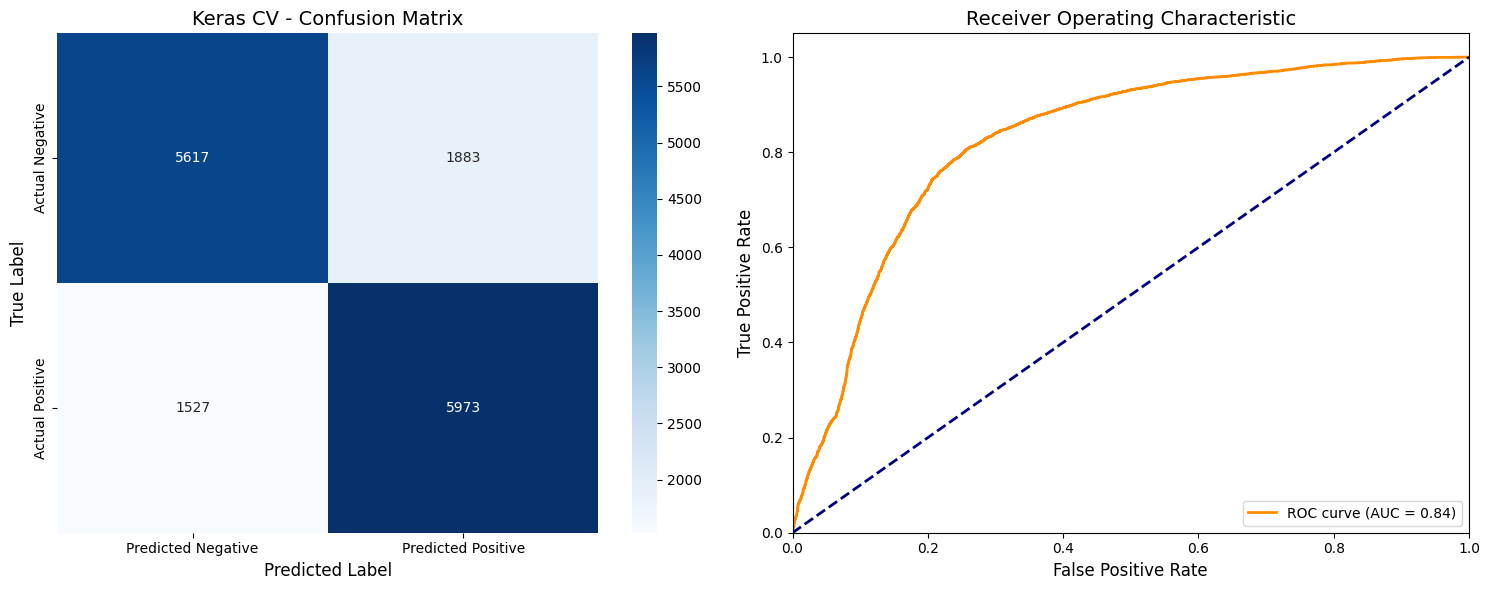

In [45]:
# Лучший AUC score: 0.

# Гиперпараметры для RNN модели
LEARNING_RATE = 0.01        # скорость обучения
BATCH_SIZE = 256           # размер батча
RNN_UNITS = 8              # количество нейронов в RNN слое
EMBEDDING_DIM = 10         # размерность эмбеддингов слов

DROPOUT_RATE = 0.5         # dropout для предотвращения переобучения
RECCURENT_DROPOUT_RATE = 0 # dropout для рекуррентных соединений
DROPOUT_LAYER_RATE = 0.0   # dropout для дополнительных слоев

REGULARIZATION_STRENGTH = 0.0001  # сила L2 регуляризации

# Функция создания RNN модели
def build_rnn_model():
    model = Sequential([
        # Слой эмбеддингов: преобразует индексы токенов в плотные векторы
        Embedding(input_dim=MAX_NUM_WORDS + 1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                    embeddings_regularizer=l2_reg(REGULARIZATION_STRENGTH)),
        
        # Двунаправленная RNN: анализирует последовательность в обе стороны
        Bidirectional(SimpleRNN(RNN_UNITS, dropout=DROPOUT_RATE, recurrent_dropout=RECCURENT_DROPOUT_RATE, return_sequences=False)),
        
        # Выходной слой для бинарной классификации
        Dense(1, activation="sigmoid")
    ])
    
    # Компилируем модель с оптимизатором Adam
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.build((None, MAX_SEQUENCE_LENGTH))
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["AUC"])
    return model

# Параметры обучения
fit_params = dict(
    epochs=50,  # максимальное количество эпох
    batch_size=BATCH_SIZE,
    callbacks=[EarlyStopping(monitor='auc', mode='max', patience=5, restore_best_weights=True)],  # ранняя остановка
    verbose=1
)

# Обучаем RNN модель с кросс-валидацией
rnn_metrics = cross_validate_model(
    model_builder=build_rnn_model,
    X=X['review'],
    y=y,
    preprocessor=RNN_preprocessor,
    cv=cv,
    fit_params=fit_params
)

In [46]:
# Результаты обучения RNN модели
print_metrics_beautifully(rnn_metrics)

🎯 MODEL: Keras CV

📊 ОСНОВНЫЕ МЕТРИКИ:
----------------------------------------------------------------------
  ROC AUC              :          0.8362
  F1 Score             :          0.7722
  Precision            :          0.7748
  Recall               :          0.7727
  Accuracy             :          0.7727
  Training Time        :         443.36s

🔍 CONFUSION MATRIX:
----------------------------------------------------------------------
                 Predicted Negative  Predicted Positive
Actual Negative                5617                1883
Actual Positive                1527                5973

  True Negatives:  5617
  False Positives: 1883
  False Negatives: 1527
  True Positives:  5973

⚙️  МОДЕЛИ (CV):
----------------------------------------------------------------------
  Количество моделей: 3
  Fold 1: sequential_3
  Fold 2: sequential_4
  Fold 3: sequential_5

📈 ROC CURVE:
----------------------------------------------------------------------
  FPR samples: 4856


## 3. CNN (Сверточная нейронная сеть)

**Логика:** CNN применяет сверточные фильтры к последовательности токенов, выявляя локальные паттерны.
GlobalMaxPooling1D выбирает наиболее важные признаки из всей последовательности.
CNN часто работают быстрее RNN и могут выявлять n-граммы эффективнее.

Fold 1


/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 600, 20)        │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 598, 8)         │           488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 8)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,517 (9.83 KB)

 Trainable params: 2,517 (9.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - AUC: 0.8049 - loss: 0.5843
Epoch 2/50
16/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8566 - loss: 0.5174

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `auc` which is not available. Available metrics are: AUC,loss
  current = self.get_monitor_value(logs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8569 - loss: 0.5126
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.8621 - loss: 0.5025
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - AUC: 0.8642 - loss: 0.4989
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8655 - loss: 0.4957
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8682 - loss: 0.4904
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8709 - loss: 0.4832
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8712 - loss: 0.4842
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8729 - loss: 0.4807
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8730 - loss: 0.4792
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8761 - loss: 0.4728
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.8754 - loss: 0.4739
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8769 - loss: 0.4714
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 600, 20)        │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 598, 8)         │           488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 8)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,517 (9.83 KB)

 Trainable params: 2,517 (9.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.8152 - loss: 0.5718
Epoch 2/50
19/79 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8543 - loss: 0.5246

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `auc` which is not available. Available metrics are: AUC,loss
  current = self.get_monitor_value(logs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.8591 - loss: 0.5069
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.8632 - loss: 0.4971
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.8656 - loss: 0.4929
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.8689 - loss: 0.4860
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.8690 - loss: 0.4856
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.8730 - loss: 0.4785
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.8725 - loss: 0.4806
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.8752 - loss: 0.4764
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.8755 - loss: 0.4763
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.8757 - loss: 0.4758
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.8774 - loss: 0.4721
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8793 - loss: 0.4694
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/ste

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 600, 20)        │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 598, 8)         │           488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_5          │ (None, 8)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,517 (9.83 KB)

 Trainable params: 2,517 (9.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - AUC: 0.8177 - loss: 0.5712
Epoch 2/50
11/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8426 - loss: 0.5351

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `auc` which is not available. Available metrics are: AUC,loss
  current = self.get_monitor_value(logs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.8586 - loss: 0.5106
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8615 - loss: 0.5039
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8638 - loss: 0.4988
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8668 - loss: 0.4935
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8670 - loss: 0.4934
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8699 - loss: 0.4887
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.8728 - loss: 0.4836
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.8721 - loss: 0.4840
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8749 - loss: 0.4799
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.8749 - loss: 0.4801
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8754 - loss: 0.4796
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8775 - loss: 0.4749
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/

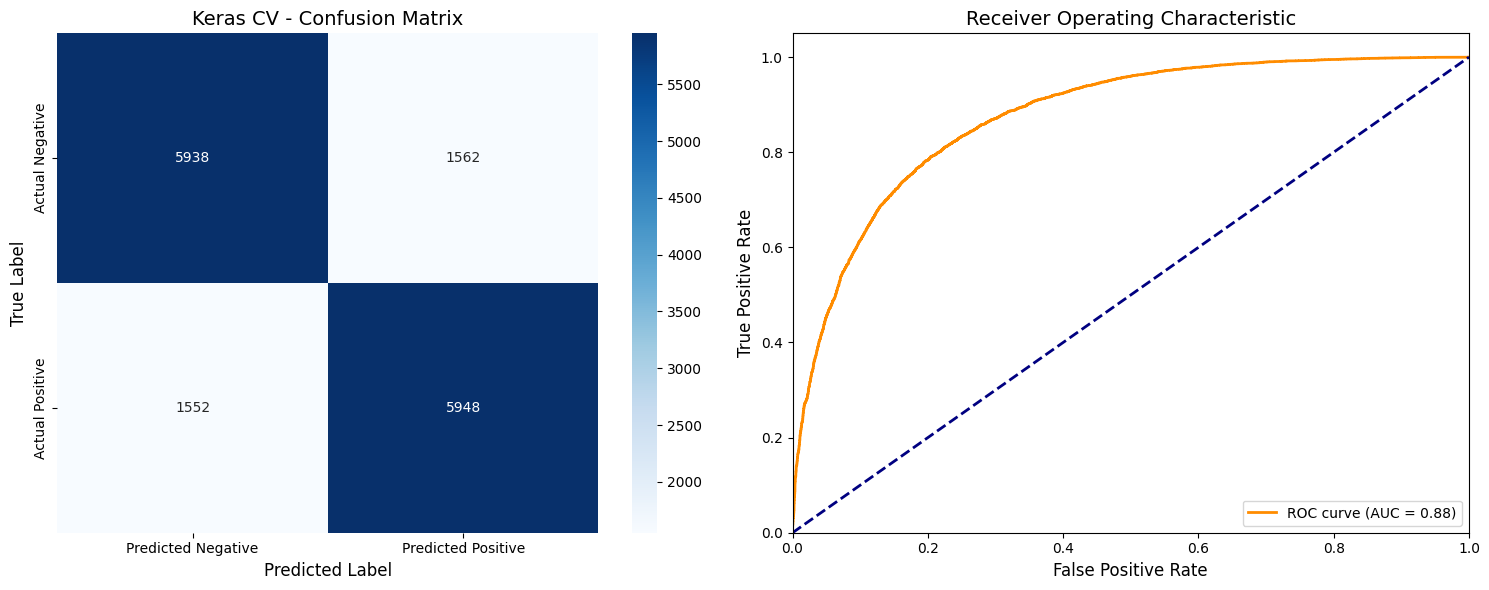

In [47]:
# Гиперпараметры для CNN модели
LEARNING_RATE = 0.01
BATCH_SIZE = 128          # меньший батч для CNN
FILTERS = 8               # количество сверточных фильтров
KERNEL_SIZE = 3           # размер ядра свертки (3-граммы)
EMBEDDING_DIM = 20        # больше размерность эмбеддингов для CNN

DROPOUT_RATE = 0.5
DROPOUT_LAYER_RATE = 0.0

REGULARIZATION_STRENGTH = 0.01

# Функция создания CNN модели
def build_cnn_model():
    model = Sequential([
        # Слой эмбеддингов
        Embedding(input_dim=MAX_NUM_WORDS + 1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                  embeddings_regularizer=l2_reg(REGULARIZATION_STRENGTH)),
        
        # Сверточный слой: выявляет локальные паттерны (n-граммы)
        Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
        
        # Глобальное максимальное пулирование: выбирает наиболее важные признаки
        GlobalMaxPooling1D(),
        
        # Выходной слой для бинарной классификации
        Dense(1, activation="sigmoid")
    ])
    
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.build((None, MAX_SEQUENCE_LENGTH))
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["AUC"])
    return model

# Параметры обучения
fit_params = dict(
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=[EarlyStopping(monitor='auc', mode='max', patience=5, restore_best_weights=True)],
    verbose=1
)

# Обучаем CNN модель с кросс-валидацией
cnn_metrics = cross_validate_model(
    model_builder=build_cnn_model,
    X=X['review'],
    y=y,
    preprocessor=RNN_preprocessor,  # Используем тот же препроцессор, что и для RNN
    cv=cv,
    fit_params=fit_params
)

In [48]:
# Результаты обучения CNN модели
print_metrics_beautifully(cnn_metrics)


🎯 MODEL: Keras CV

📊 ОСНОВНЫЕ МЕТРИКИ:
----------------------------------------------------------------------
  ROC AUC              :          0.8754
  F1 Score             :          0.7923
  Precision            :          0.7930
  Recall               :          0.7924
  Accuracy             :          0.7924
  Training Time        :         151.00s

🔍 CONFUSION MATRIX:
----------------------------------------------------------------------
                 Predicted Negative  Predicted Positive
Actual Negative                5938                1562
Actual Positive                1552                5948

  True Negatives:  5938
  False Positives: 1562
  False Negatives: 1552
  True Positives:  5948

⚙️  МОДЕЛИ (CV):
----------------------------------------------------------------------
  Количество моделей: 3
  Fold 1: sequential_6
  Fold 2: sequential_7
  Fold 3: sequential_8

📈 ROC CURVE:
----------------------------------------------------------------------
  FPR samples: 4428


Fold 1


/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 600, 20)        │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 16)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,893 (15.21 KB)

 Trainable params: 3,893 (15.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - AUC: 0.7600 - loss: 0.6145
Epoch 2/50
 1/79 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - AUC: 0.8097 - loss: 0.5992

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `auc` which is not available. Available metrics are: AUC,loss
  current = self.get_monitor_value(logs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - AUC: 0.8232 - loss: 0.5697
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - AUC: 0.8430 - loss: 0.5385
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - AUC: 0.8520 - loss: 0.5214
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - AUC: 0.8602 - loss: 0.5070
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - AUC: 0.8614 - loss: 0.5074
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - AUC: 0.8638 - loss: 0.5022
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - AUC: 0.8663 - loss: 0.4974
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - AUC: 0.8664 - loss: 0.4988
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - AUC: 0.8670 - loss: 0.4985
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - AUC: 0.8682 - loss: 0.4962
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - AUC: 0.8721 - loss: 0.4909
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - AUC: 0.8709 - loss: 0.4927
Epoch 14/50
79/79 ━━━━━━━━━━━━

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 600, 20)        │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 16)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,893 (15.21 KB)

 Trainable params: 3,893 (15.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - AUC: 0.7944 - loss: 0.5837
Epoch 2/50
 1/79 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - AUC: 0.8479 - loss: 0.5843

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `auc` which is not available. Available metrics are: AUC,loss
  current = self.get_monitor_value(logs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - AUC: 0.8534 - loss: 0.5209
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - AUC: 0.8589 - loss: 0.5098
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - AUC: 0.8574 - loss: 0.5110
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - AUC: 0.8653 - loss: 0.4977
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - AUC: 0.8664 - loss: 0.4970
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - AUC: 0.8664 - loss: 0.4980
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - AUC: 0.8711 - loss: 0.4885
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - AUC: 0.8716 - loss: 0.4888
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - AUC: 0.8736 - loss: 0.4837
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - AUC: 0.8737 - loss: 0.4890
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - AUC: 0.8670 - loss: 0.5005
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - AUC: 0.8714 - loss: 0.4926
Epoch 14/50
79/79 ━━━━━━

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 600, 20)        │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 16)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,893 (15.21 KB)

 Trainable params: 3,893 (15.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - AUC: 0.7814 - loss: 0.5958
Epoch 2/50
 1/79 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - AUC: 0.8413 - loss: 0.5511

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `auc` which is not available. Available metrics are: AUC,loss
  current = self.get_monitor_value(logs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - AUC: 0.8414 - loss: 0.5396
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - AUC: 0.8528 - loss: 0.5227
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - AUC: 0.8546 - loss: 0.5187
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - AUC: 0.8600 - loss: 0.5094
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - AUC: 0.8628 - loss: 0.5046
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - AUC: 0.8586 - loss: 0.5119
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - AUC: 0.8636 - loss: 0.5028
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - AUC: 0.8628 - loss: 0.5041
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - AUC: 0.8624 - loss: 0.5059
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - AUC: 0.8683 - loss: 0.4966
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - AUC: 0.8669 - loss: 0.5000
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - AUC: 0.8674 - loss: 0.4986
Epoch 14/50
79/79 ━━━━━━━━━━━━

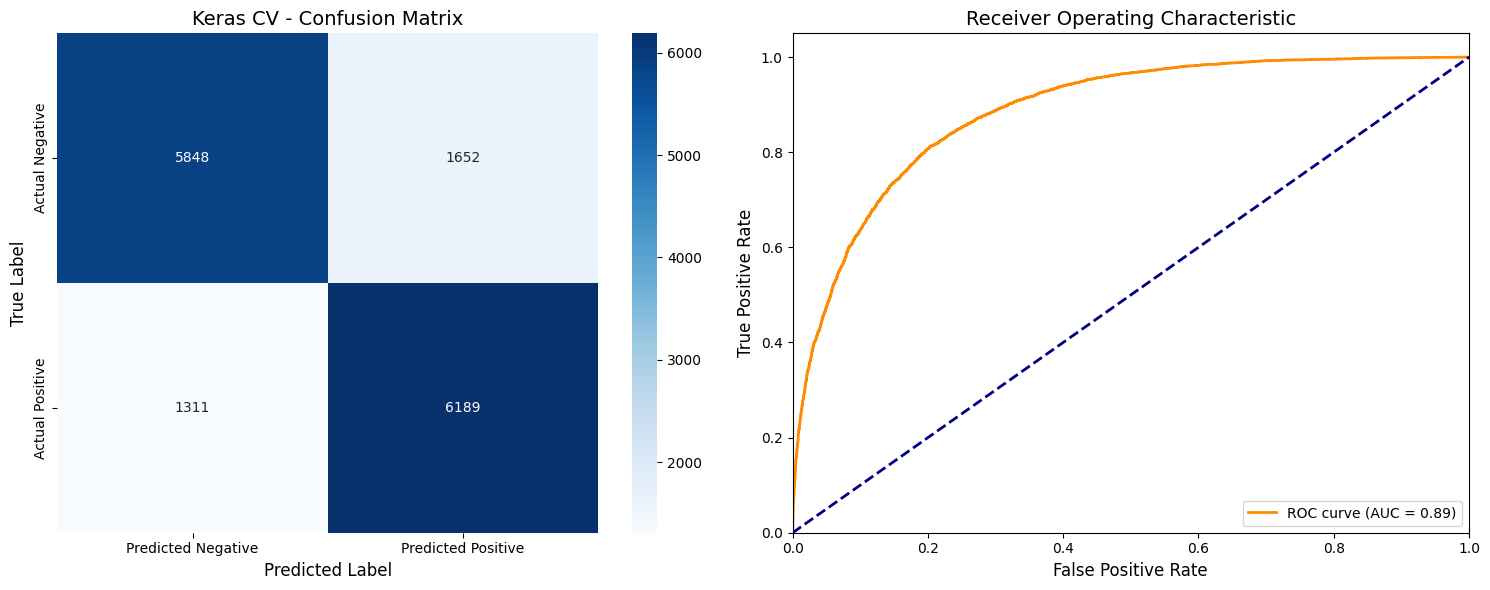

In [49]:
# Гиперпараметры для LSTM модели
LEARNING_RATE = 0.01
BATCH_SIZE = 128
LSTM_UNITS = 8            # количество нейронов в LSTM слое
EMBEDDING_DIM = 20

DROPOUT_RATE = 0.5
RECCURENT_DROPOUT_RATE = 0
DROPOUT_LAYER_RATE = 0.0

REGULARIZATION_STRENGTH = 0.01

# Функция создания LSTM модели
def build_lstm_model():
    model = Sequential([
        # Слой эмбеддингов
        Embedding(input_dim=MAX_NUM_WORDS + 1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                  embeddings_regularizer=l2_reg(REGULARIZATION_STRENGTH)),
        
        # Двунаправленная LSTM: более сложная архитектура для работы с долгосрочными зависимостями
        Bidirectional(LSTM(LSTM_UNITS, dropout=DROPOUT_RATE, recurrent_dropout=RECCURENT_DROPOUT_RATE, return_sequences=False)),
        
        # Выходной слой для бинарной классификации
        Dense(1, activation="sigmoid")
    ])
    
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.build((None, MAX_SEQUENCE_LENGTH))
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["AUC"])
    return model

# Параметры обучения
fit_params = dict(
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=[EarlyStopping(monitor='auc', mode='max', patience=5, restore_best_weights=True)],
    verbose=1
)

# Обучаем LSTM модель с кросс-валидацией
lstm_metrics = cross_validate_model(
    model_builder=build_lstm_model,
    X=X['review'],
    y=y,
    preprocessor=RNN_preprocessor,  # Используем тот же препроцессор
    cv=cv,
    fit_params=fit_params
)

In [50]:
# Результаты обучения LSTM модели
print_metrics_beautifully(lstm_metrics)


🎯 MODEL: Keras CV

📊 ОСНОВНЫЕ МЕТРИКИ:
----------------------------------------------------------------------
  ROC AUC              :          0.8859
  F1 Score             :          0.8022
  Precision            :          0.8039
  Recall               :          0.8025
  Accuracy             :          0.8025
  Training Time        :        1489.62s

🔍 CONFUSION MATRIX:
----------------------------------------------------------------------
                 Predicted Negative  Predicted Positive
Actual Negative                5848                1652
Actual Positive                1311                6189

  True Negatives:  5848
  False Positives: 1652
  False Negatives: 1311
  True Positives:  6189

⚙️  МОДЕЛИ (CV):
----------------------------------------------------------------------
  Количество моделей: 3
  Fold 1: sequential_9
  Fold 2: sequential_10
  Fold 3: sequential_11

📈 ROC CURVE:
----------------------------------------------------------------------
  FPR samples: 419

Fold 1


/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 600, 100)       │     2,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 598, 8)         │         2,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_8          │ (None, 8)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,002,617 (7.64 MB)

 Trainable params: 2,417 (9.44 KB)

 Non-trainable params: 2,000,200 (7.63 MB)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 0.7795 - loss: 0.5632
Epoch 2/50
 7/79 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.8516 - loss: 0.4892

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `auc` which is not available. Available metrics are: AUC,loss
  current = self.get_monitor_value(logs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - AUC: 0.8643 - loss: 0.4585
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - AUC: 0.8728 - loss: 0.4450
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.8766 - loss: 0.4388
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - AUC: 0.8796 - loss: 0.4339
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - AUC: 0.8829 - loss: 0.4280
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - AUC: 0.8837 - loss: 0.4263
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - AUC: 0.8863 - loss: 0.4216
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - AUC: 0.8882 - loss: 0.4185
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.8895 - loss: 0.4159
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.8911 - loss: 0.4130
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 0.8925 - loss: 0.4102
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.8928 - loss: 0.4098
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 600, 100)       │     2,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 598, 8)         │         2,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_9          │ (None, 8)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,002,617 (7.64 MB)

 Trainable params: 2,417 (9.44 KB)

 Non-trainable params: 2,000,200 (7.63 MB)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.8283 - loss: 0.5067
Epoch 2/50
 7/79 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - AUC: 0.8339 - loss: 0.5188

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `auc` which is not available. Available metrics are: AUC,loss
  current = self.get_monitor_value(logs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.8695 - loss: 0.4507
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - AUC: 0.8763 - loss: 0.4399
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - AUC: 0.8808 - loss: 0.4325
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - AUC: 0.8831 - loss: 0.4283
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - AUC: 0.8844 - loss: 0.4260
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - AUC: 0.8865 - loss: 0.4221
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - AUC: 0.8882 - loss: 0.4192
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - AUC: 0.8889 - loss: 0.4177
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - AUC: 0.8906 - loss: 0.4150
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - AUC: 0.8909 - loss: 0.4142
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.8916 - loss: 0.4129
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - AUC: 0.8925 - loss: 0.4113
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 600, 100)       │     2,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 598, 8)         │         2,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_10         │ (None, 8)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,002,617 (7.64 MB)

 Trainable params: 2,417 (9.44 KB)

 Non-trainable params: 2,000,200 (7.63 MB)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - AUC: 0.8400 - loss: 0.4940
Epoch 2/50
 7/79 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.8716 - loss: 0.4493

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `auc` which is not available. Available metrics are: AUC,loss
  current = self.get_monitor_value(logs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - AUC: 0.8746 - loss: 0.4430
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - AUC: 0.8820 - loss: 0.4307
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - AUC: 0.8864 - loss: 0.4230
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - AUC: 0.8904 - loss: 0.4157
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - AUC: 0.8932 - loss: 0.4106
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - AUC: 0.8947 - loss: 0.4078
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.8975 - loss: 0.4026
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - AUC: 0.8994 - loss: 0.3992
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - AUC: 0.9004 - loss: 0.3971
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 0.9011 - loss: 0.3955
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - AUC: 0.9019 - loss: 0.3940
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - AUC: 0.9034 - loss: 0.3912
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/

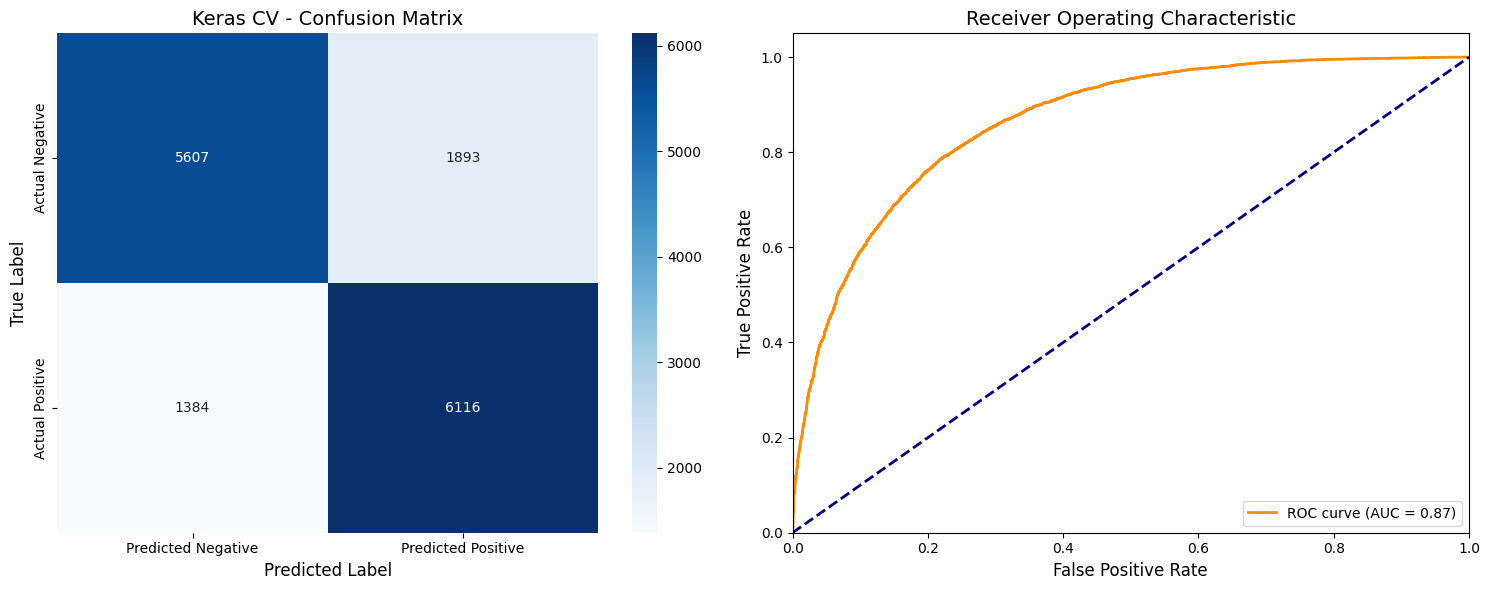

In [52]:
# Загружаем предобученные GloVe эмбеддинги для улучшения качества модели
from typing import Dict, Tuple
import numpy as np

# Параметры GloVe эмбеддингов
GLOVE_DIM: int = 100           # размерность GloVe векторов
GLOVE_MAX_VOCAB: int = 20000   # количество GloVe слов (исключая PAD/OOV)
GLOVE_PATH: str = 'glove.6B.100d.txt'  # путь к файлу GloVe

def _load_glove_fixed_vocab(path: str, embedding_dim: int, max_words: int) -> Tuple[dict, np.ndarray]:
    """Загружает GloVe эмбеддинги и создает словарь с фиксированным размером"""
    vocab: Dict[str, int] = {'<PAD>': 0, '<OOV>': 1}  # специальные токены
    matrix = [np.zeros(embedding_dim, dtype='float32'), np.zeros(embedding_dim, dtype='float32')]

    added = 0
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            if added >= max_words:
                break
            parts = line.rstrip().split(' ')
            if len(parts) < embedding_dim + 1:
                continue
            token = parts[0]
            if token in vocab:  # пропускаем дубликаты
                continue
            vec = np.asarray(parts[1:], dtype='float32')
            if vec.shape[0] != embedding_dim:
                continue
            # присваиваем следующий ID начиная с 2
            idx = len(vocab)
            vocab[token] = idx
            matrix.append(vec)
            added += 1

    embedding_matrix = np.vstack(matrix)
    return vocab, embedding_matrix

# Загружаем GloVe эмбеддинги
_glove_vocab, _glove_matrix = _load_glove_fixed_vocab(GLOVE_PATH, GLOVE_DIM, GLOVE_MAX_VOCAB)

# Создаем препроцессор с фиксированным словарем GloVe
GLOVE_preprocessor = Pipeline([
    ('token_selector', NgramFeatureSelector(top_k=MAX_NUM_WORDS)),
    ('seq_vec', SequenceVectorizer(
        vocabulary=_glove_vocab,  # используем фиксированный словарь
        max_sequence_length=MAX_SEQUENCE_LENGTH,
        pad_left=False,
    )),
])

# CNN с замороженными GloVe эмбеддингами
def build_cnn_glove_fixed_model():
    model = Sequential([
        # Слой эмбеддингов с предобученными GloVe весами (замороженными)
        Embedding(
            input_dim=_glove_matrix.shape[0],
            output_dim=_glove_matrix.shape[1],
            input_length=MAX_SEQUENCE_LENGTH,
            weights=[_glove_matrix],
            trainable=False,  # замораживаем веса эмбеддингов
        ),
        Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(1, activation='sigmoid'),
    ])
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.build((None, MAX_SEQUENCE_LENGTH))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])
    return model

# Обучаем CNN с GloVe эмбеддингами
cnn_glove_fixed_metrics = cross_validate_model(
    model_builder=build_cnn_glove_fixed_model,
    X=X['review'],
    y=y,
    preprocessor=GLOVE_preprocessor,
    cv=cv,
    fit_params=fit_params,
)

In [ ]:
print_metrics_beautifully( cnn_glove_fixed_metrics)

🎯 MODEL: Keras CV

📊 ОСНОВНЫЕ МЕТРИКИ:
----------------------------------------------------------------------
  ROC AUC              :          0.8511
  F1 Score             :          0.7706
  Precision            :          0.7739
  Recall               :          0.7712
  Accuracy             :          0.7712
  Training Time        :         100.36s

🔍 CONFUSION MATRIX:
----------------------------------------------------------------------
                 Predicted Negative  Predicted Positive
Actual Negative                1834                 666
Actual Positive                 478                2022

  True Negatives:  1834
  False Positives: 666
  False Negatives: 478
  True Positives:  2022

⚙️  МОДЕЛИ (CV):
----------------------------------------------------------------------
  Количество моделей: 3
  Fold 1: sequential
  Fold 2: sequential_1
  Fold 3: sequential_2

📈 ROC CURVE:
----------------------------------------------------------------------
  FPR samples: 1660
  TP

In [85]:
#Собираем метрики и присваиваем имена для сравнения
all_metrics = {
    'RNN': rnn_metrics,
    'CNN': cnn_metrics,
    'LSTM': lstm_metrics,
    'CNN GloVe': cnn_glove_fixed_metrics
}
for name, metric in all_metrics.items():
    metric.name = name

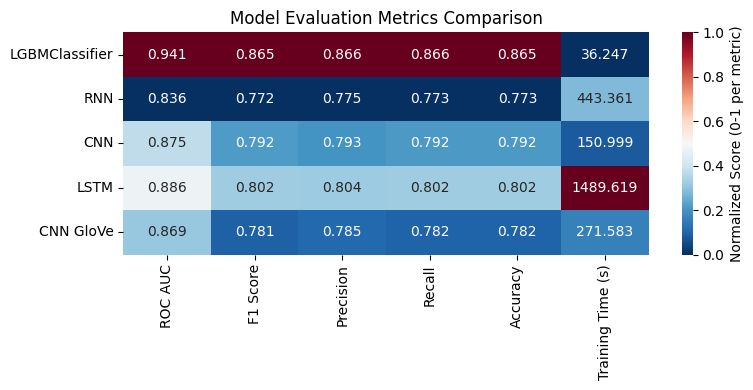

In [86]:
# Сравниваем результаты всех обученных моделей
# Тепловая карта покажет, какая модель показала наилучшие результаты
plot_metrics_heatmap([
        baseline_metrics,      # LGBM baseline
        rnn_metrics,          # RNN нейронная сеть
        cnn_metrics,          # CNN нейронная сеть
        lstm_metrics,         # LSTM нейронная сеть
        cnn_glove_fixed_metrics # CNN с предобученными GloVe эмбеддингами
    ]
)

**Можно заметить, что нейросети не смогли опередить базовый эстиматор, поэтому перейдем к подбору гиперпараметров на ранее отобранных лучших фичах**